In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import urllib

In [3]:
# read in the modeled streamflow file
# open_mfdataset allow you to read multiple files at the same time
model_ds = xr.open_mfdataset("01205500.h.****-01-01-00000.nc")

In [4]:
# define the USGS site id
site_id = "01205500"

# define the outlet id
#
# we will need to use this outlet id to
# find the corresponding river segment in 
# the model simulation
#
# This outlet id can be found on your
# spatialweight or ntopo file
#
outlet_id = 73004474

In [5]:
model_ds

<xarray.Dataset> Size: 4MB
Dimensions:         (time: 2189, seg: 99, hru: 99)
Coordinates:
  * time            (time) datetime64[ns] 18kB 1990-01-03 ... 1995-12-31
Dimensions without coordinates: seg, hru
Data variables:
    reachID         (time, seg) int32 867kB dask.array<chunksize=(365, 99), meta=np.ndarray>
    basinID         (time, hru) int32 867kB dask.array<chunksize=(365, 99), meta=np.ndarray>
    basRunoff       (time, hru) float32 867kB dask.array<chunksize=(1, 99), meta=np.ndarray>
    dlayRunoff      (time, seg) float32 867kB dask.array<chunksize=(1, 99), meta=np.ndarray>
    KWroutedRunoff  (time, seg) float32 867kB dask.array<chunksize=(1, 99), meta=np.ndarray>
Attributes:
    mizuRoute-version:  v1.2.3
    gitBranch:          main-0-g0a62ee6
    gitHash:            0a62ee6185bdc9b99cd88ed5f15ea850602c43a2

# How to find the correct `seg` when we know the outlet_id

`reachID` denotes the ID for all river segment, including the outlet. 

Therefore, we need to figure out the location of outlet_id in `reachID`

In [6]:
# First, we extract the reachID for all river segments
reach_id_all = model_ds.reachID.isel(time=0).values

# Then we find the `seg` value for all river segments
seg_id_all = model_ds.seg.values

# Finally, we use "np.where(reach_id_all==outlet_id)[0][0]" to
# find the index of the correct segment, and corresponding 
# `seg` value for the outlet
seg_id = seg_id_all[np.where(reach_id_all==outlet_id)[0][0]]
print(seg_id)

82


In [7]:
# let's select the flow outlet
sim_flow_outlet = model_ds['KWroutedRunoff'].sel(seg = seg_id)

In [8]:
# It is important to note that the unit for flow simulation is
# m3/sec. We need to convert it to ft3/sec.
cms_2_cfs = 35.3147
sim_flow_outlet_cfs = sim_flow_outlet * cms_2_cfs

In [9]:
sim_flow_outlet_cfs.load()

<xarray.DataArray 'KWroutedRunoff' (time: 2189)> Size: 9kB
array([7.3152427e-03, 1.4622134e-01, 8.0977118e-01, ..., 9.3853204e+02,
       9.0377350e+02, 8.8042261e+02], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 18kB 1990-01-03 1990-01-04 ... 1995-12-31

# Download USGS dataset

In [10]:
# Here we define a function to download USGS data
def download_usgs_data(site_id,start_date='1990-01-01',end_date='2023-12-31'):
    args = {
        'site_no': site_id,
        'begin_date': start_date,
        'end_date': end_date
    }
    query = urllib.parse.urlencode(args)
    verde_url = (
        f'https://waterdata.usgs.gov/nwis/dv?'
        f'cb_00060=on&format=rdb&referred_module=sw&{query}'
    )
    response = urllib.request.urlopen(verde_url)
    df = pd.read_table(
        response,
        comment='#',
        sep='\s+',
        names=['agency', 'site', 'date', 'streamflow', 'quality_flag'],
        index_col=2,
        parse_dates=True,
        date_format='yyyy-mm-dd',
        engine='python'
    )
    # discard the first two rows
    df = df.iloc[2:]
    # Now convert the streamflow data to floats and
    # the index to datetimes. When processing raw data
    # it's common to have to do some extra postprocessing
    df['streamflow'] = df['streamflow'].astype(np.float64)
    df.index = pd.DatetimeIndex(df.index)
    return df

In [11]:
# we download the USGS data for corresponding site
# if you do not specify the start_date or end_date
# this function will automatically download data 
# between 1990-01-01 and 2023-12-31

# of course you may specify the start and end dates

df_usgs = download_usgs_data(site_id)

In [12]:
df_usgs

,agency,site,streamflow,quality_flag
date,,,,
1990-01-01,USGS,01205500,1040.0,A
1990-01-02,USGS,01205500,2460.0,A
1990-01-03,USGS,01205500,2620.0,A
1990-01-04,USGS,01205500,2270.0,A
1990-01-05,USGS,01205500,1680.0,A
...,...,...,...,...
2023-12-27,USGS,01205500,6710.0,P
2023-12-28,USGS,01205500,11800.0,P
2023-12-29,USGS,01205500,9900.0,P


In [13]:
# we find the overlapping period between our simulation
# and the observation
# we also would like to get rid of the first year of model 
# simulation just for spin-up purpose
start_date = np.max([df_usgs.index.values[0], sim_flow_outlet_cfs.time.values[0], np.datetime64('1991-01-01')])
end_date = np.min([df_usgs.index.values[-1], sim_flow_outlet_cfs.time.values[-1]])

print("start date for evaluation is %s"%start_date)
print("end date for evaluation is %s"%end_date)


start date for evaluation is 1991-01-01T00:00:00.000000000
end date for evaluation is 1995-12-31T00:00:00.000000000


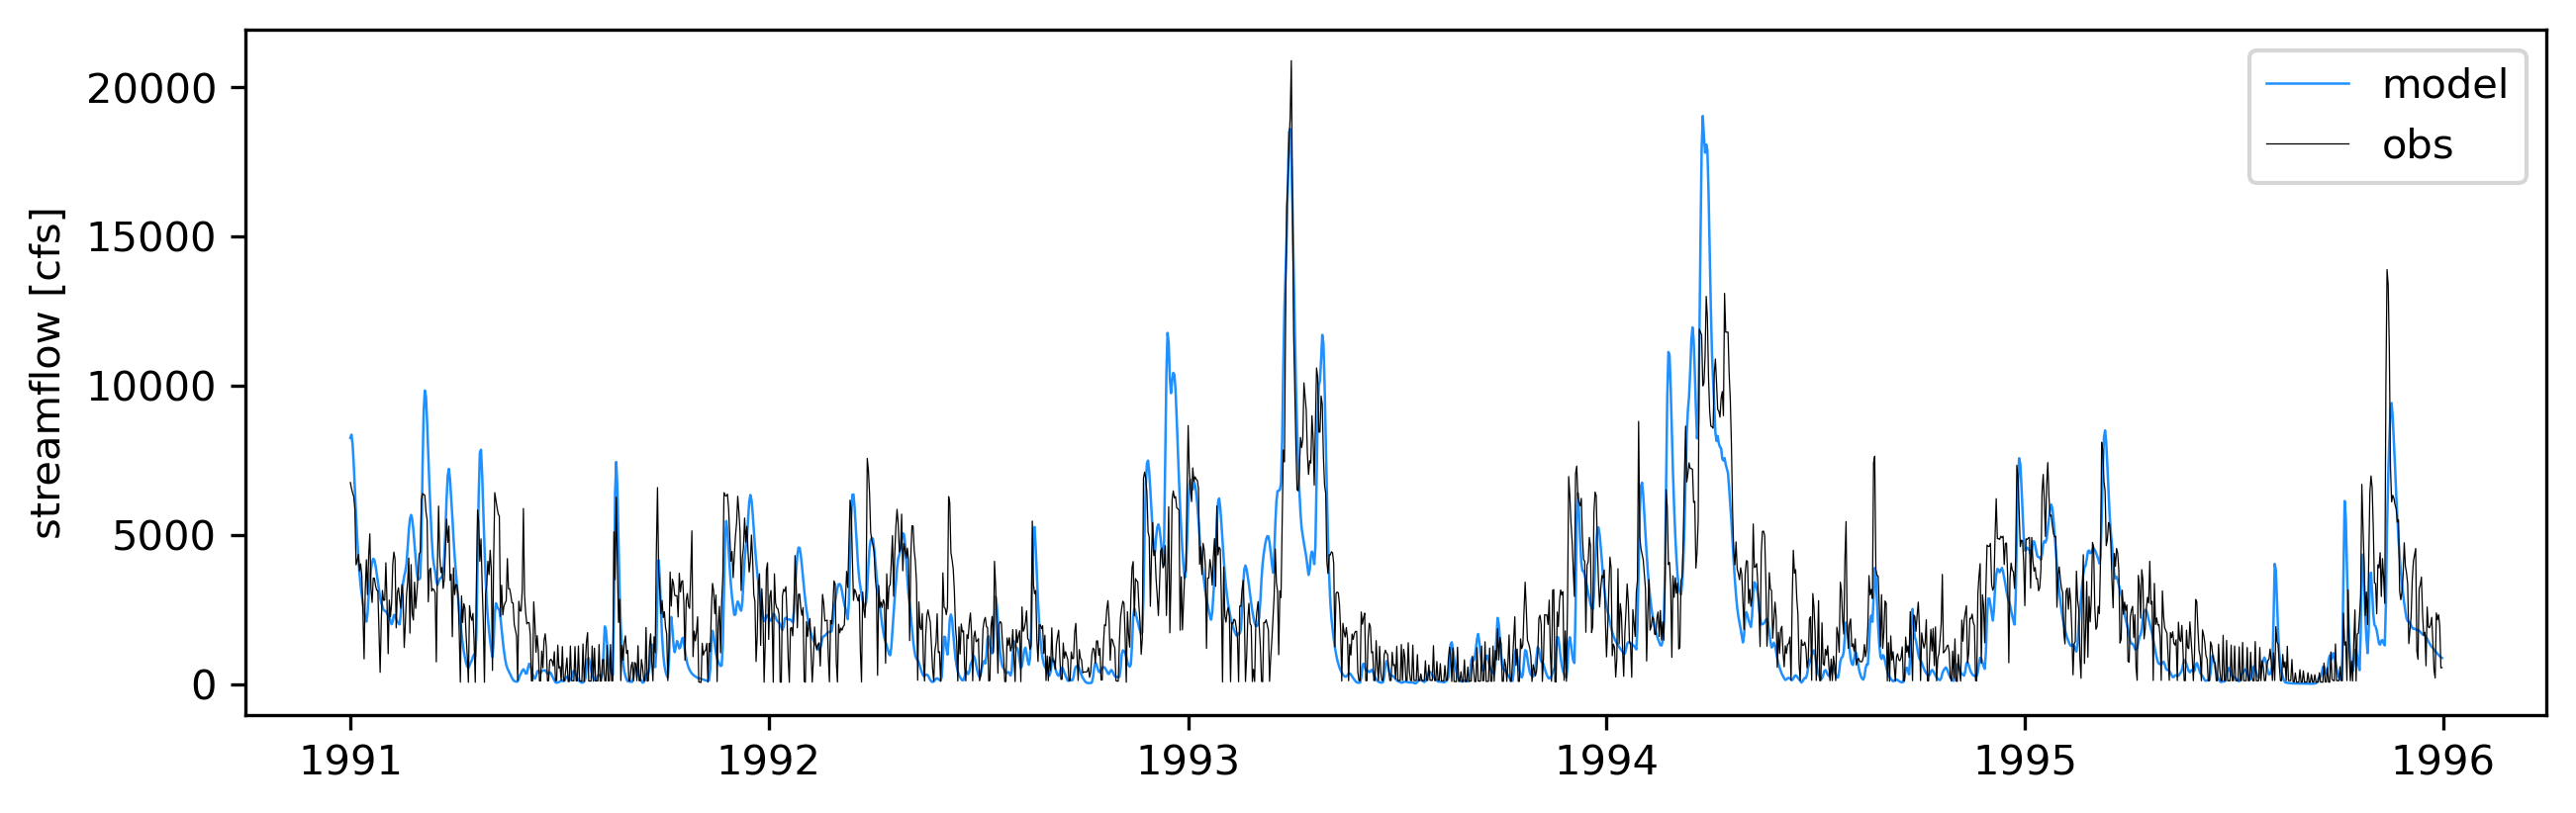

In [14]:
# truncate the data to fit the start and end date
df_usgs_sel = df_usgs.loc[slice(start_date,end_date)]
sim_flow_outlet_cfs_sel = sim_flow_outlet_cfs.sel(time=slice(start_date,end_date))


# plotting
plt.figure(figsize=[10,3],dpi=300)
plt.plot(sim_flow_outlet_cfs_sel.time, sim_flow_outlet_cfs_sel, lw=0.6,c='dodgerblue',label='model')
plt.plot(df_usgs_sel.index.values, df_usgs_sel['streamflow'],lw=0.3,c='k',label='obs')
plt.ylabel("streamflow [cfs]")
plt.legend()

In [15]:
import calendar
month_abbr = [calendar.month_abbr[i] for i in range(1,13)]

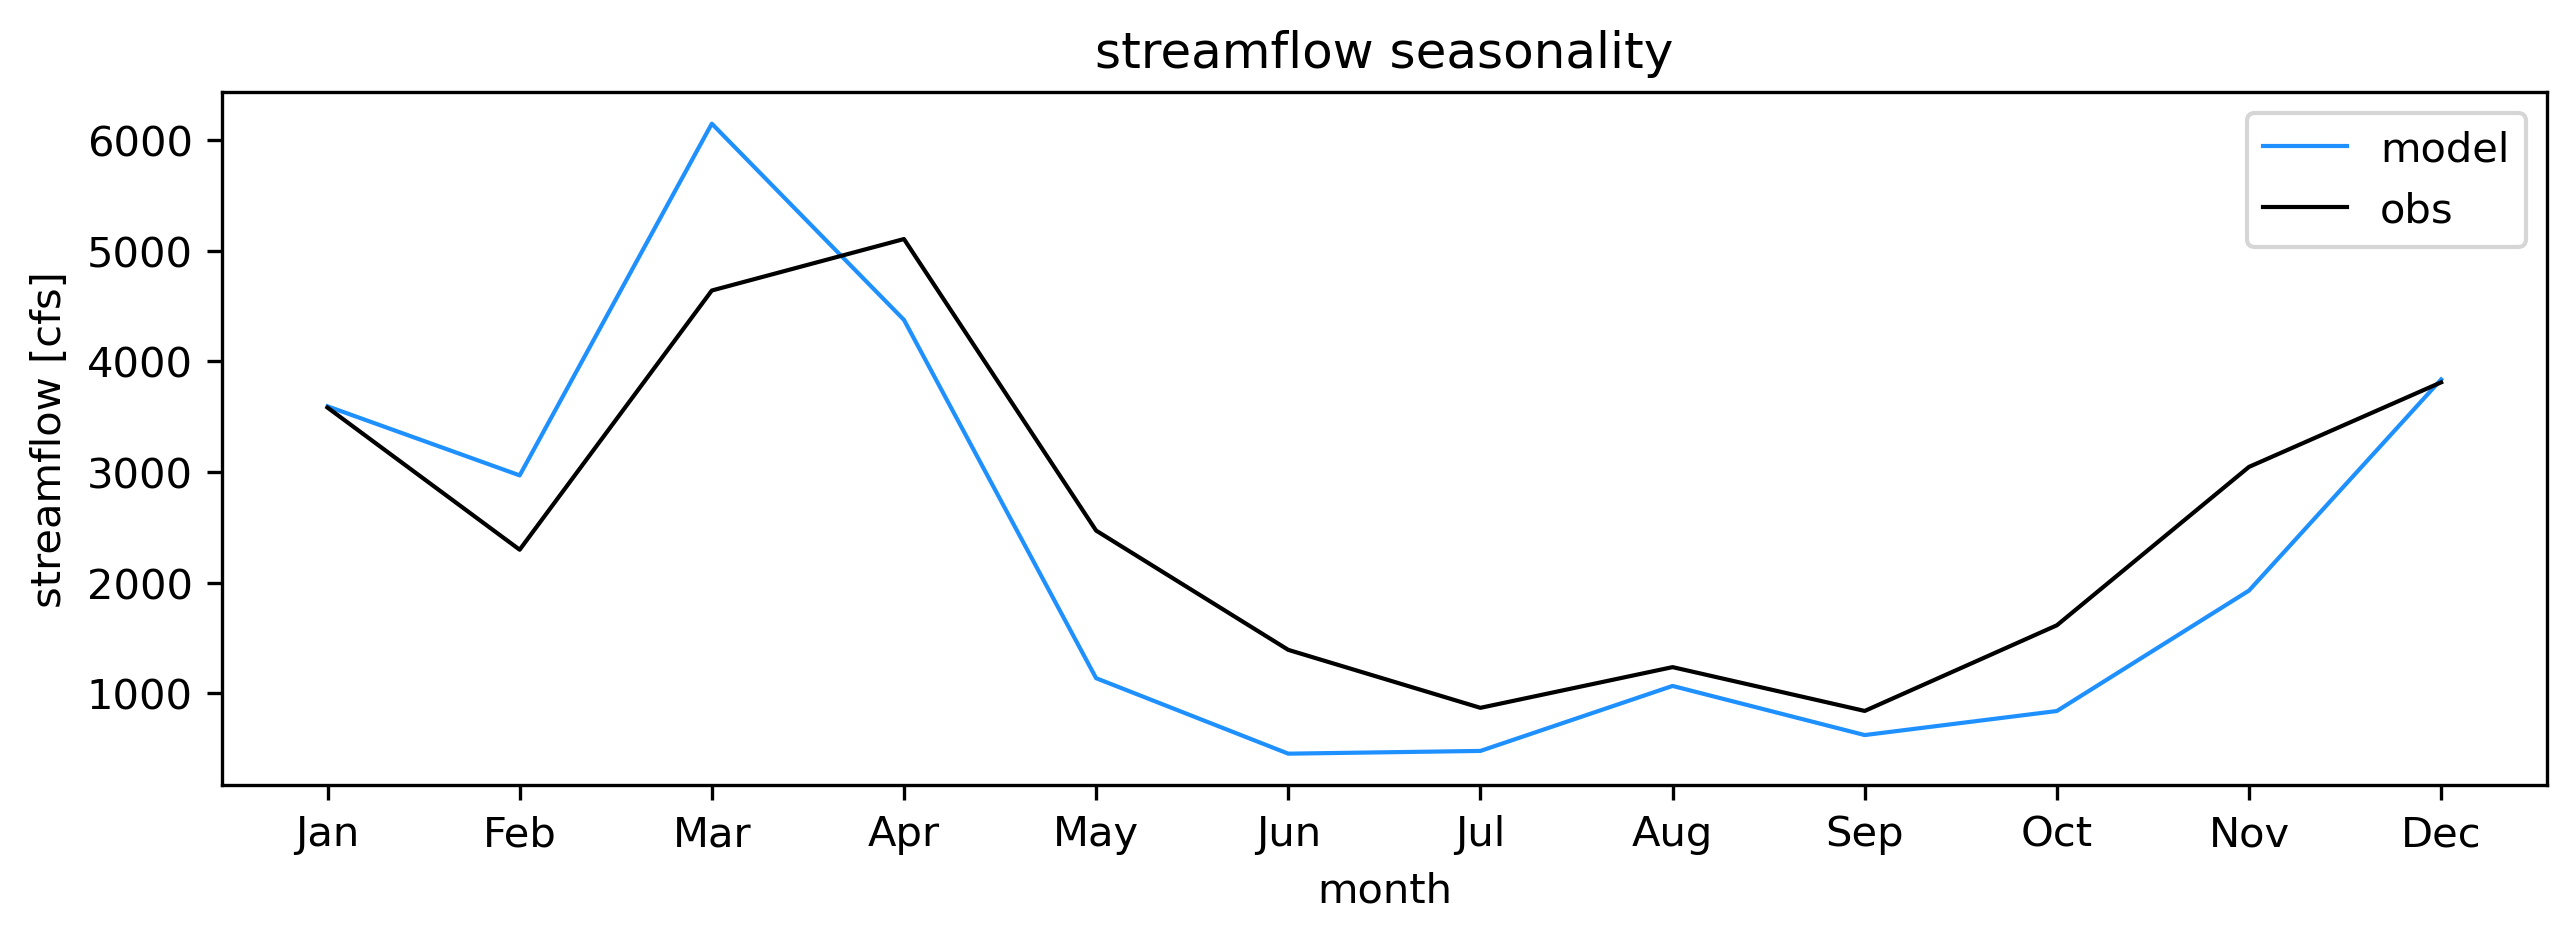

In [16]:
fig,ax= plt.subplots(1,1,figsize=[10,3],dpi=300)
sim_flow_outlet_cfs_sel.groupby(sim_flow_outlet_cfs_sel.time.dt.month).mean().plot(ax=ax,lw=1, color='dodgerblue',label='model')
df_usgs_sel['streamflow'].groupby(df_usgs_sel.index.month).mean().plot(ax=ax,lw=1, color='k',label='obs')
ax.set_xlabel("month")
ax.set_ylabel("streamflow [cfs]")
ax.set_title("streamflow seasonality")
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(month_abbr)
ax.legend()